In [5]:
import numpy as np
from cvxpy import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [6]:
# load data.
beta = np.loadtxt("projectdata.txt")

# 1 Uncertainty Model

## Cross-validation

In [7]:
def uncertainty_model_cv(beta, p):
    n = len(beta)
    # create the H matrix, split the traning and validation set
    H_all = np.zeros(p*n).reshape(n, p)
    for i in np.arange(p):
        H_all[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
    beta_validation = beta[-6:]
    H_p = H_all[p:-6, :]
    H_validation = H_all[-6:, :]
    beta_p = beta[p:-6]
    # solve the optimization problem
    sigma_hat = Variable(1)
    theta_hat = Variable(p)
    prob = Problem(Minimize(sigma_hat), 
                   [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                    sigma_hat > 0])
    prob.solve()
    # calculate the error
    error = H_validation.dot(np.array(theta_hat.value)).flatten()-\
    beta_validation
    # calculate the mean absolute error
    mae = sum(np.abs(error))/6
    n_excess_bound = sum(np.abs(error)-sigma_hat.value > 0)
    return sigma_hat.value, theta_hat.value, mae, n_excess_bound

In [8]:
maes = []
n_excess_bounds = []
for p in np.arange(1, 31):
    theta_hats_cv = []
    maes_cv = []
    n_excess_bounds_cv = []
    for cv in np.arange(10):
        if cv == 0:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta,p)
        else:
            sigma_hat, theta_hat, mae, n_excess_bound = \
            uncertainty_model_cv(beta[:-cv],p)
        maes_cv += [mae]
        n_excess_bounds_cv += [n_excess_bound]
    maes += [np.mean(maes_cv)]
    n_excess_bounds += [np.mean(n_excess_bounds_cv)/6]

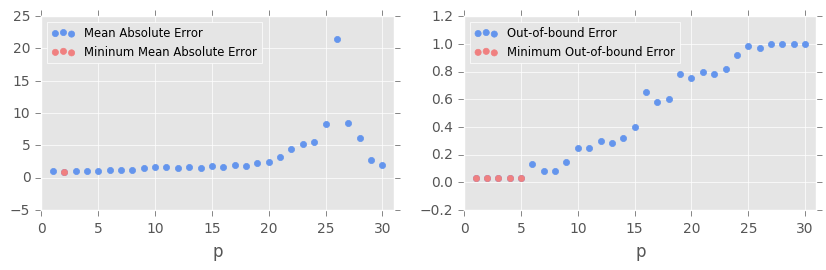

In [9]:
f, axarr = plt.subplots(1, 2, figsize=(10,2.5))
axarr[0].scatter(np.arange(1, 31), maes, 
                 label="Mean Absolute Error", 
                 color = "cornflowerblue")
axarr[0].scatter(np.arange(1, 31)[1], maes[1], 
                 color = "lightcoral", 
                 label="Mininum Mean Absolute Error")
axarr[0].legend(loc="upper left", fontsize = 'x-small')
axarr[0].set_xlim([0, 31])
axarr[0].legend(loc="upper left", fontsize = 'small')
axarr[0].set_xlabel('p')
axarr[1].scatter(np.arange(1, 31), n_excess_bounds, 
                 label="Out-of-bound Error", 
                 color = "cornflowerblue")
axarr[1].scatter(np.arange(1, 31)[:5], n_excess_bounds[:5], 
                 color = "lightcoral",
                 label="Minimum Out-of-bound Error")
axarr[1].set_xlim([0, 31])
axarr[1].legend(loc="upper left", fontsize = 'small')
axarr[1].set_xlabel('p')
f.savefig("cv.png")

# Optimization

We choose p=2 to fit our model.

In [10]:
p=2
n = len(beta)
# create the H matrix
H_p = np.zeros(p*n).reshape(n, p)
for i in np.arange(p):
    H_p[:,i] = np.concatenate([np.zeros(i+1), beta[:-(i+1)]])
beta_validation = beta[-6:]
H_p = H_p[p:, :]
beta_p = beta[p:]
# solve the optimization problem
sigma_hat = Variable(1)
theta_hat = Variable(p)
prob = Problem(Minimize(sigma_hat), 
               [norm(beta_p - H_p*theta_hat, "inf") <= sigma_hat,
                sigma_hat > 0])
prob.solve()

print(sigma_hat.value)
print(theta_hat.value)

3.24341242878
[[ 0.44904669]
 [ 0.53272938]]


# Uncertainty Model

In [11]:
sigma = sigma_hat.value
theta_1 = float(theta_hat.value[0])
theta_2 = float(theta_hat.value[1])

In [12]:
beta_t_1 = beta[-2]
beta_t = beta[-1]

In [13]:
beta_t1 = np.array([theta_1, theta_2, sigma])
beta_t2 = theta_1*np.concatenate([beta_t1, [0]]) + \
    theta_2*np.array([1, 0, 0, 0]) + \
    sigma*np.array([0, 0, 0, 1])
beta_t3 = theta_1*np.concatenate([beta_t2, [0]]) + \
    theta_2*np.concatenate([beta_t1, [0, 0]]) + \
    sigma*np.array([0, 0, 0, 0, 1])
beta_t4 = theta_1*np.concatenate([beta_t3, [0]]) + \
    theta_2*np.concatenate([beta_t2, [0, 0]]) + \
    sigma*np.array([0, 0, 0, 0, 0, 1])
beta_t5 = theta_1*np.concatenate([beta_t4, [0]]) + \
    theta_2*np.concatenate([beta_t3, [0, 0]]) + \
    sigma*np.array([0, 0, 0, 0, 0, 0, 1])
beta_t6 = theta_1*np.concatenate([beta_t5, [0]]) + \
    theta_2*np.concatenate([beta_t4, [0, 0]]) + \
    sigma*np.array([0, 0, 0, 0, 0, 0, 0, 1])

In [14]:
b_hat = np.vstack([beta_t1[:2], beta_t2[:2], beta_t3[:2], 
                   beta_t4[:2], beta_t5[:2], beta_t6[:2]]).dot(
    np.array([beta_t, beta_t_1]))
B = np.vstack([np.concatenate([beta_t1[2:], np.zeros(5)]),
              np.concatenate([beta_t2[2:], np.zeros(4)]),
              np.concatenate([beta_t3[2:], np.zeros(3)]),
              np.concatenate([beta_t4[2:], np.zeros(2)]),
              np.concatenate([beta_t5[2:], np.zeros(1)]),
              beta_t6[2:]])

In [15]:
b_hat

array([ 2.53868639,  1.93268543,  2.22029883,  2.02661616,  2.09286371,
        2.0194315 ])

In [16]:
B

array([[ 3.24341243,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.45644363,  3.24341243,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.38187229,  1.45644363,  3.24341243,  0.        ,  0.        ,
         0.        ],
       [ 1.84546219,  2.38187229,  1.45644363,  3.24341243,  0.        ,
         0.        ],
       [ 2.09759205,  1.84546219,  2.38187229,  1.45644363,  3.24341243,
         0.        ],
       [ 1.9250487 ,  2.09759205,  1.84546219,  2.38187229,  1.45644363,
         3.24341243]])

# 2 Decision Making

## Naive Strategy

In [18]:
A = np.array([[  -1.,     0,     0,     0,     0,  0,    1.,     0,     0,    1.,     0,     0,     0,     0],
              [1.003,    -1,     0,     0,     0,  0,     0,    1.,     0, -1.01,    1.,     0,     0,     0],
              [    0, 1.003,    -1,     0,     0,  0,     0,     0,    1.,     0, -1.01,    1.,     0,     0],
              [    0,     0, 1.003,    -1,     0,  0, -1.02,     0,     0,     0,     0, -1.01,    1.,     0],
              [    0,     0,     0, 1.003,    -1,  0,     0, -1.02,     0,     0,     0,     0, -1.01,    1.],
              [    0,     0,     0,     0, 1.003, -1,     0,     0, -1.02,     0,     0,     0,     0, -1.01]])

In [14]:
def naive_strategy(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= b_hat,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

In [15]:
results = []
initials = np.concatenate([5*np.arange(3, 14), [70.3]])
for i in initials:
    results += [naive_strategy(i)]
results = np.array(results)

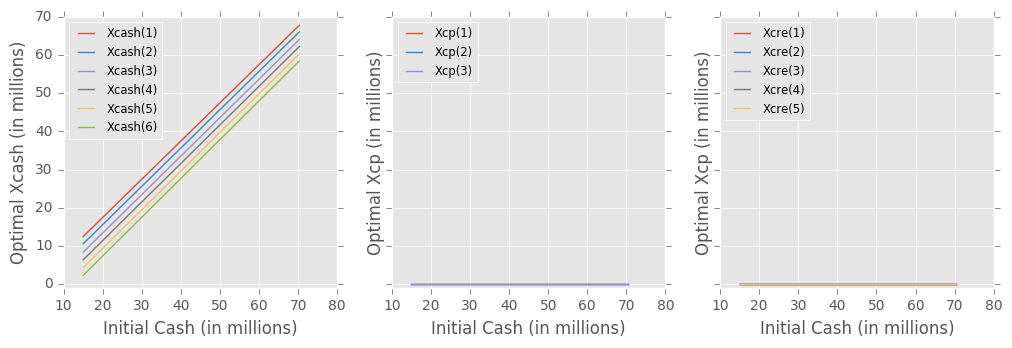

In [16]:
f, axarr = plt.subplots(1, 3, figsize=(12,3.5), sharey=True)

for i in range(6):
    axarr[0].plot(initials, results[:, i], label="Xcash("+str(i+1)+")")
axarr[0].set_ylabel("Optimal Xcash (in millions)")
axarr[0].set_xlabel("Initial Cash (in millions)")
axarr[0].legend(loc="upper left", fontsize = 'small')
axarr[0].set_ylim(-1, 70)

for i in range(6,9):
    axarr[1].plot(initials, results[:, i], label="Xcp("+str(i-5)+")")
axarr[1].set_ylabel("Optimal Xcp (in millions)")
axarr[1].set_xlabel("Initial Cash (in millions)")
axarr[1].legend(loc="upper left", fontsize = 'small')


for i in range(9,14):
    axarr[2].plot(initials, results[:, i], label="Xcre("+str(i-8)+")")
axarr[2].set_ylabel("Optimal Xcp (in millions)")
axarr[2].set_xlabel("Initial Cash (in millions)")
axarr[2].legend(loc="upper left", fontsize = 'small')

f.savefig("naive.png")

In [17]:
naive_strategy(12.739)

array([  1.02003136e+01,   8.29822913e+00,   6.10282498e+00,
         4.09451729e+00,   2.01393713e+00,   5.47434858e-04,
         2.55473286e-09,   2.35630540e-09,   2.06510531e-09,
         3.13112467e-09,   3.47454313e-09,   3.34967904e-09,
         3.69410390e-09,   3.76604109e-09])

In [18]:
# if we let the initial cash drop below 12.739 million, 
# the problem will become infeasible
naive_strategy(12.738)

array([None, None, None], dtype=object)

In [19]:
x_cash_naive = results[-1][:6]
x_cp_naive = results[-1][6:9]
x_cre_naive = results[-1][9:]

In [20]:
print("When initial funds equal to 70.3 million, \n" + 
      "the excess funds to be invested from January to June is " + 
      str(results[-1][0].round(4)) + ", " + 
      str(results[-1][1].round(4)) + ", " + 
      str(results[-1][2].round(4)) + ", " + 
      str(results[-1][3].round(4)) + ", " + 
      str(results[-1][4].round(4)) + ", " + 
      str(results[-1][5].round(4)) + ". \n" +
      "The commercial paper to be issued in the first three month is " +
      str(results[-1][6].round(4)) + ", " + 
      str(results[-1][7].round(4)) + ", " + 
      str(results[-1][8].round(4)) + ". " + 
      "The balance int he credit line should be " +
      str(results[-1][9].round(4)) + ", " + 
      str(results[-1][10].round(4)) + ", " + 
      str(results[-1][11].round(4)) + ", " + 
      str(results[-1][12].round(4)) + ", " + 
      str(results[-1][13].round(4)) + ". ")

When initial funds equal to 70.3 million, 
the excess funds to be invested from January to June is 67.7613, 66.0319, 64.0097, 62.1751, 60.2688, 58.4302. 
The commercial paper to be issued in the first three month is 0.0, 0.0, 0.0. The balance int he credit line should be 0.0, 0.0, 0.0, 0.0, 0.0. 


The results shows that if we have enough intial funds, say 70.3 million, the optimal solution for the LP problem will not turn to crefit line nor commercial paper. 

As we decrease the amount of initial funds, the optimal value of excess funds to be invested $X_{cash}$ will decrease linearly. However, the optimal amount for credit line $X_{cre}$ and commercial paper $X_{cp}$ will stay 0. When the initial funds drops below 12.739 million, the problem will become infeasible.

## Robust Strategy

In [21]:
def robust_strategy(C_initial):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + abs(B)*np.ones(6).T,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

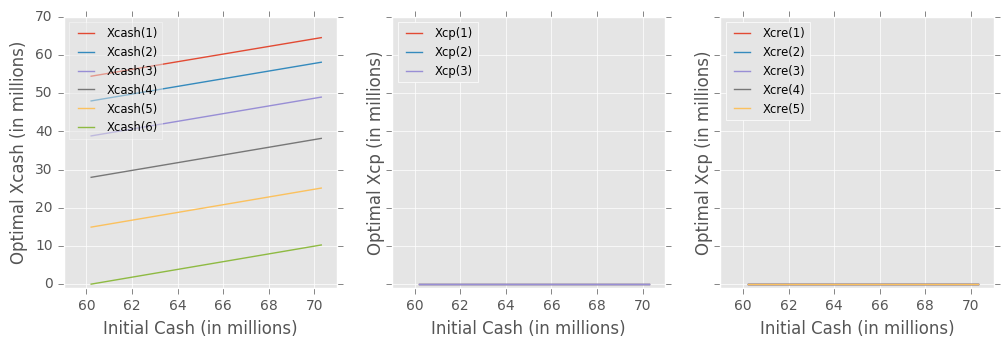

In [23]:
f, axarr = plt.subplots(1, 3, figsize=(12,3.5), sharey=True, sharex=True)

for i in range(6):
    axarr[0].plot(initials, results[:, i], label="Xcash("+str(i+1)+")")
axarr[0].set_ylabel("Optimal Xcash (in millions)")
axarr[0].set_xlabel("Initial Cash (in millions)")
axarr[0].legend(loc="upper left", fontsize = 'small', framealpha=0.5)
axarr[0].set_ylim(-1, 70)
axarr[0].set_xlim(59, 71)

for i in range(6,9):
    axarr[1].plot(initials, results[:, i], label="Xcp("+str(i-5)+")")
axarr[1].set_ylabel("Optimal Xcp (in millions)")
axarr[1].set_xlabel("Initial Cash (in millions)")
axarr[1].legend(loc="upper left", fontsize = 'small')


for i in range(9,14):
    axarr[2].plot(initials, results[:, i], label="Xcre("+str(i-8)+")")
axarr[2].set_ylabel("Optimal Xcp (in millions)")
axarr[2].set_xlabel("Initial Cash (in millions)")
axarr[2].legend(loc="upper left", fontsize = 'small')

f.savefig("robust.png")

In [24]:
robust_strategy(60.2053)

array([  5.44232012e+01,   4.79539293e+01,   3.87957639e+01,
         2.79583445e+01,   1.49245732e+01,   8.41485092e-05,
         2.16230748e-09,   2.16225937e-09,   2.18668800e-09,
         3.35017521e-09,   3.30391697e-09,   3.32680858e-09,
         3.33767216e-09,   3.35939180e-09])

In [25]:
robust_strategy(60.2052)

array([None, None, None], dtype=object)

In [26]:
x_cash_robust = results[-1][:6]
x_cp_robust = results[-1][6:9]
x_cre_robust = results[-1][9:]

In [27]:
print("When initial funds equal to 70.3 million, \n" + 
      "the excess funds to be invested from January to June is " + 
      str(results[-1][0].round(4)) + ", " + str(results[-1][1].round(4)) + ", " + 
      str(results[-1][2].round(4)) + ", " + str(results[-1][3].round(4)) + ", " + 
      str(results[-1][4].round(4)) + ", " + str(results[-1][5].round(4)) + ". \n" +
      "The commercial paper to be issued in the first three month is " +
      str(results[-1][6].round(4)) + ", " + str(results[-1][7].round(4)) + ", " + 
      str(results[-1][8].round(4)) + ". " + 
      "The balance int he credit line should be " +
      str(results[-1][9].round(4)) + ", " + str(results[-1][10].round(4)) + ", " + 
      str(results[-1][11].round(4)) + ", " + str(results[-1][12].round(4)) + ", " + 
      str(results[-1][13].round(4)) + ". ")

When initial funds equal to 70.3 million, 
the excess funds to be invested from January to June is 64.5179, 58.0789, 48.9511, 38.1442, 25.141, 10.2471. 
The commercial paper to be issued in the first three month is 0.0, 0.0, 0.0. The balance int he credit line should be 0.0, 0.0, 0.0, 0.0, 0.0. 


The results shows that if we have enough intial funds, say 70.3 million, the robust solution for the LP problem will not turn to crefit line nor commercial paper as well.

As we decrease the amount of initial funds, the optimal value of excess funds to be invested $X_{cash}$ will decrease linearly. However, the optimal amount for credit line $X_{cre}$ and commercial paper $X_{cp}$ will stay 0. When the initial funds drops below 60.205 million, the problem will become infeasible.

## Affine Strategy

In [24]:
def affine_strategy(C_initial, return_all = False):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    X_Cash = Variable(6, 6)
    X_Cp = Variable(3, 6)
    X_Cre = Variable(5, 6)
    
    constraints = [A*vstack(x_cash,x_cp,x_cre) + C_initial_array >= \
                   b_hat + \
                   sum_entries(abs(B - A*vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   vstack(x_cash,x_cp,x_cre) >= \
                   sum_entries(abs(vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                   x_cre + sum_entries(abs(X_Cre), axis=1) <= 1]
    
    for i in range(6):
        constraints += [X_Cash[i, i:] == 0]
    for i in range(3):
        constraints += [X_Cp[i, i:] == 0]
    for i in range(5):
        constraints += [X_Cre[i, i:] == 0]

    prob = Problem(Maximize(x_cash[5]-sum(abs(X_Cash[-1, :]))), 
               constraints)
    prob.solve()
    
    if return_all:
        return [np.array(x_cash.value).flatten(), 
                np.array(x_cp.value).flatten(), 
                np.array(x_cre.value).flatten(),
                np.array(X_Cash.value), 
                np.array(X_Cp.value), 
                np.array(X_Cre.value)]
    
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

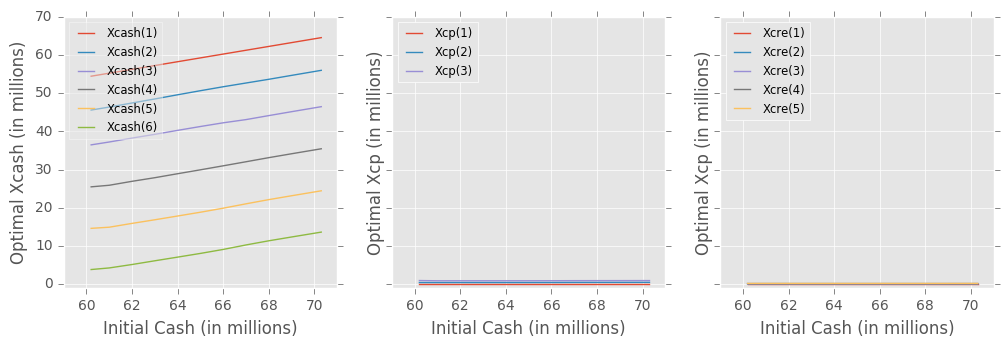

In [30]:
f, axarr = plt.subplots(1, 3, figsize=(12,3.5), sharey=True, sharex=True)

for i in range(6):
    axarr[0].plot(initials, results[:, i], label="Xcash("+str(i+1)+")")
axarr[0].set_ylabel("Optimal Xcash (in millions)")
axarr[0].set_xlabel("Initial Cash (in millions)")
axarr[0].legend(loc="upper left", fontsize = 'small', framealpha=0.5)
axarr[0].set_ylim(-1, 70)
axarr[0].set_xlim(59, 71)

for i in range(6,9):
    axarr[1].plot(initials, results[:, i], label="Xcp("+str(i-5)+")")
axarr[1].set_ylabel("Optimal Xcp (in millions)")
axarr[1].set_xlabel("Initial Cash (in millions)")
axarr[1].legend(loc="upper left", fontsize = 'small')


for i in range(9,14):
    axarr[2].plot(initials, results[:, i], label="Xcre("+str(i-8)+")")
axarr[2].set_ylabel("Optimal Xcp (in millions)")
axarr[2].set_xlabel("Initial Cash (in millions)")
axarr[2].legend(loc="upper left", fontsize = 'small')

f.savefig("robust.png")

In [29]:
affine_strategy(60.2053)

array([  5.44232012e+01,   4.55633680e+01,   3.64523564e+01,
         2.54649014e+01,   1.45982761e+01,   3.81828688e+00,
         7.74488763e-11,   4.13669801e-01,   9.38132895e-01,
         1.10063501e-10,   5.65713026e-02,   9.77400520e-02,
         1.45125467e-01,   1.75036120e-01])

In [32]:
affine_strategy(60.2051)

array([None, None, None], dtype=object)

In [33]:
# solve the problem where the initial fund equals to 
x_cash_affine, x_cp_affine, x_cre_affine, X_Cash_affine, X_Cp_affine, X_Cre_affine = affine_strategy(70.3, True)

In [34]:
x_cash_affine.round(4)

array([ 64.5179,  55.9582,  46.4463,  35.428 ,  24.4255,  13.6159])

In [35]:
x_cp_affine.round(4)

array([ 0.   ,  0.467,  0.929])

In [36]:
x_cre_affine.round(4)

array([ 0.    ,  0.061 ,  0.1038,  0.1483,  0.1787])

In [37]:
X_Cash_affine.round(3)

array([[-0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 2.121, -0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 1.279,  1.226, -0.   ,  0.   ,  0.   , -0.   ],
       [ 0.831,  0.818,  1.067, -0.   ,  0.   ,  0.   ],
       [ 0.128,  0.121,  0.124,  0.343,  0.   ,  0.   ],
       [-0.583, -0.645, -0.71 , -0.797, -0.633, -0.   ]])

In [38]:
X_Cp_affine.round(4)

array([[ 0.    , -0.    , -0.    , -0.    , -0.    , -0.    ],
       [-0.467 ,  0.    , -0.    , -0.    , -0.    , -0.    ],
       [-0.4656, -0.4635, -0.    , -0.    , -0.    , -0.    ]])

In [39]:
X_Cre_affine.round(4)

array([[ 0.    , -0.    , -0.    , -0.    , -0.    , -0.    ],
       [-0.061 ,  0.    , -0.    , -0.    , -0.    , -0.    ],
       [-0.0518, -0.0519, -0.    , -0.    , -0.    ,  0.    ],
       [-0.0493, -0.0495, -0.0496, -0.    , -0.    , -0.    ],
       [-0.0446, -0.0446, -0.0447, -0.0448, -0.    , -0.    ]])

As we decrease the amount of initial funds, the optimal value of excess funds to be invested $X_{cash}$ will decrease linearly. However, the optimal amount for credit line $X_{cre}$ and commercial paper $X_{cp}$ will stay 0. When the initial funds drops below 60.205 million, the problem will become infeasible.

# Relative Robust Strategy

In [40]:
import itertools

In [41]:
C_initial = 70.3
LP_step_1 = []
for element in itertools.product([-1, 1], repeat=6):
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + B.dot(np.asarray(element)),
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    LP_step_1 += [x_cash.value[5]]

In [42]:
max_LP_step_1 = max(LP_step_1)

In [43]:
x_cash = Variable(6, 1)
x_cp = Variable(3, 1)
x_cre = Variable(5, 1)
gamma = Variable(1)
prob = Problem(Minimize(gamma), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= \
                b_hat + abs(B)*np.ones(6).T,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0,
                gamma >= -1*x_cash[5] + max_LP_step_1])
prob.solve()

96.366085174644

In [44]:
x_cash_relative_robust = x_cash.value
x_cp_relative_robust = x_cp.value
x_cre_relative_robust = x_cre.value

In [45]:
print(x_cash.value.round(4))
print(x_cp.value.round(4))
print(x_cre.value.round(4))

[[ 64.5179]
 [ 58.0789]
 [ 48.9511]
 [ 38.1442]
 [ 25.141 ]
 [ 10.2471]]
[[ 0.]
 [ 0.]
 [ 0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]


# 3 Evaluation Metrics

In [46]:
# load data.
test_data = np.loadtxt("test_data.txt")
more_test_data = np.genfromtxt("more_test_data.txt", delimiter=',')

In [47]:
def test(test):    
    C_initial = 70.3
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0]).reshape(6, 1)
    x_cash = Variable(6, 1)
    x_cp = Variable(3, 1)
    x_cre = Variable(5, 1)
    prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash, x_cp, x_cre) + C_initial_array >= test,
                x_cre <= 1, x_cre >=0, x_cp >= 0, x_cash >= 0])
    prob.solve()
    return np.concatenate([np.array(x_cash.value).flatten(), 
                           np.array(x_cp.value).flatten(), 
                           np.array(x_cre.value).flatten()])

def is_cover(x_cash, x_cp, x_cre, test_data):
    C_initial = 70.3
    C_initial_array = np.array([C_initial, 0, 0, 0, 0, 0])
    return A.dot(np.concatenate([np.asarray(x_cash).flatten(), 
                                 np.asarray(x_cp).flatten(), 
                                 np.asarray(x_cre).flatten(), ])) + \
            C_initial_array >= test_data
    
def calculate_u(b_hat, B, test_data):
    return np.linalg.inv(B).dot(test_data - b_hat)

def calculate_decision_affine(test_data):
    u = calculate_u(b_hat, B, test_data)
    x_cash_affine_decision = x_cash_affine + X_Cash_affine.dot(u)
    x_cp_affine_decision = x_cp_affine + X_Cp_affine.dot(u)
    x_cre_affine_decision = x_cre_affine + X_Cre_affine.dot(u)
    return x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision

In [48]:
optimal = test(test_data)[5]
optimal

67.145094066411431

## naive strategy

In [49]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_naive, x_cp_naive, x_cre_naive, test_data))
print("regret:")
regret_naive = optimal - x_cash_naive[5]
print(regret_naive)

whether the strategy will cover the required liability in the test data:
[ True False  True  True  True  True]
regret:
8.71493557903


## robust strategy

In [50]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_robust, x_cp_robust, x_cre_robust, test_data))
print("regret:")
regret_robust = optimal - x_cash_robust[5]
print(regret_robust)

whether the strategy will cover the required liability in the test data:
[ True  True  True  True  True  True]
regret:
56.8979781687


## affine strategy

In [51]:
# calculate the trategy
x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision = calculate_decision_affine(test_data)
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_affine_decision, x_cp_affine_decision, 
         x_cre_affine_decision, test_data))
print("regret:")
regret_affine = optimal - x_cash_affine_decision[5]
print(regret_affine)

whether the strategy will cover the required liability in the test data:
[ True  True  True  True  True  True]
regret:
52.9698251978


## relative robust strategy

In [52]:
print("whether the strategy will cover the required liability in the test data:")
print(is_cover(x_cash_relative_robust, x_cp_relative_robust, 
         x_cre_relative_robust, test_data))
print("regret:")
regret_relative_robust = optimal - x_cash_relative_robust[5]
print(regret_relative_robust)

whether the strategy will cover the required liability in the test data:
[ True  True  True  True  True  True]
regret:
[[ 56.89797817]]


## more test data

In [53]:
results = []
is_cover_naive = []
is_cover_robust = []
is_cover_affine = []
is_cover_relative_robust = []
regret_naive = []
regret_robust = []
regret_affine = []
regret_relative_robust = []
for i in more_test_data:
    results += [test(i)[5]]
    optimal = test(i)[5]
    x_cash_affine_decision, x_cp_affine_decision, x_cre_affine_decision = calculate_decision_affine(i)
    
    is_cover_naive += [np.mean(is_cover(x_cash_naive, x_cp_naive, 
                                x_cre_naive, i))]
    is_cover_robust += [np.mean(is_cover(x_cash_robust, x_cp_robust, x_cre_robust, test_data))]
    is_cover_affine += [np.mean(is_cover(x_cash_affine_decision, x_cp_affine_decision, 
                               x_cre_affine_decision, test_data))]
    is_cover_relative_robust += [np.mean(is_cover(x_cash_relative_robust, 
                                          x_cp_relative_robust, 
                                          x_cre_relative_robust, i))]
    regret_naive += [optimal-x_cash_naive[5]]
    regret_robust += [optimal-x_cash_robust[5]]
    regret_affine += [optimal-x_cash_affine_decision[5]]
    regret_relative_robust += [optimal-x_cash_relative_robust[5][0, 0]]

In [54]:
print("naive strategy")
unique, counts = np.unique(is_cover_naive, return_counts=True)
print(np.asarray((unique, counts)).T)
print("robust strategy")
unique, counts = np.unique(is_cover_robust, return_counts=True)
print(np.asarray((unique, counts)).T)
print("affine strategy")
unique, counts = np.unique(is_cover_affine, return_counts=True)
print(np.asarray((unique, counts)).T)
print("robust strategy")
unique, counts = np.unique(is_cover_relative_robust, return_counts=True)
print(np.asarray((unique, counts)).T)

naive strategy
[[  0.83333333   6.        ]
 [  1.          14.        ]]
robust strategy
[[  1.  20.]]
affine strategy
[[  1.  20.]]
robust strategy
[[  1.  20.]]


Fromt the above results, XXXXXXXXXX XXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXX XXXXXXXXXXXXXXXXXX XXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXXXX XXXXXX XXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXX XXXX XXXXXXXXXX XXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXX XXXXX XXXX XXXX XXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXX XXXXXXXXXXXXX XXXXXXXXXXXXX XXXXXXXXXXXX XXXX XXX XXXXXXXXXXXXXXXXX XXXXX XXX XXXXXXXXXX XXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXX XXXXXXX XXXX XXXX XXXXXXXXX XXXX XXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXX XXXXXXXXXX XXXX XXXX XXX XX XXX XX XXXXXXXXXXXXX XXXXXXXXX XXXXXXXXXXXX XXXXXXXXX XXXX XXXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXX XXX XXX XXXXX XXXXXX XXXXX XXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXX XXXXXXXXXXXX XXXXXXXXXXXXXXXXX XXXXXXXXXXXX XXX XXXXXX

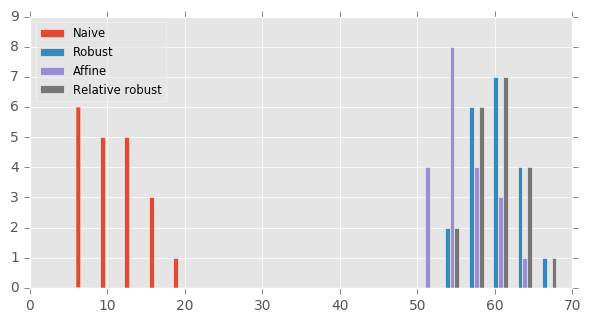

In [55]:
plt.figure(figsize=(7,3.5))
plt.hist([regret_naive, regret_robust, 
          regret_affine, regret_relative_robust], 
         20, histtype='bar', 
         label=["Naive", "Robust", "Affine", "Relative robust"])
# plt.title('Regret histogram of more test data')
plt.legend(loc="upper left", fontsize = 'small', framealpha=0.5)
plt.ylim(0, 9)
plt.savefig("regret.png")

# 4 Reproduction of the livebook example

## Naive Strategy

In [56]:
b_hat = np.array([150, 100, -200, 200, -50, -300])
x_cash = Variable(6)
x_cp = Variable(3)
x_cre = Variable(5)
prob = Problem(Maximize(x_cash[5]), 
               [A[:, :6]*x_cash + A[:, 6:9]*x_cp + \
                A[:, 9:]*x_cre >= \
                b_hat,
                x_cre <= 100, x_cre >=0, x_cp >= 0, x_cash >= 0])
prob.solve()

92.49694914597907

In [57]:
print(x_cash.value.round(4))
print(x_cp.value.round(4))
print(x_cre.value.round(4))

[[   0.    ]
 [   0.    ]
 [ 351.9442]
 [   0.    ]
 [   0.    ]
 [  92.4969]]
[[ 150.    ]
 [  74.2977]
 [ 177.9035]]
[[  0.    ]
 [ 25.7023]
 [  0.    ]
 [  0.    ]
 [ 25.7836]]


## Robust Strategy

In [58]:
# robust problem in the livebook
b_hat = np.array([150, 100, -200, 200, -50, -300])
B=np.diag(b_hat).dot(np.array([[.06,   0,   0,   0,   0,   0],
                            [.02, .06,   0,   0,   0,   0],
                            [  0, .02, .06,   0,   0,   0],
                            [  0,   0, .02, .06,   0,   0],
                            [  0,   0,   0, .02, .06,   0],
                            [  0,   0,   0,   0, .02, .06]]))
x_cash = Variable(6, 1)
x_cp = Variable(3, 1)
x_cre = Variable(5, 1)
prob = Problem(Maximize(x_cash[5]), 
               [A*vstack(x_cash,x_cp,x_cre) >= \
                b_hat + abs(B)*np.ones(6).T,
                x_cre <= 100, x_cre >=0, x_cp >= 0, x_cash >= 0])
prob.solve()

14.288569470597606

In [59]:
print(x_cash.value.round(4))
print(x_cp.value.round(4))
print(x_cre.value.round(4))

[[   0.    ]
 [   0.    ]
 [ 377.0489]
 [   0.    ]
 [   0.    ]
 [  14.2886]]
[[ 159.    ]
 [  71.6477]
 [ 229.7647]]
[[  0.    ]
 [ 36.3523]
 [  0.    ]
 [  0.    ]
 [ 27.0807]]


## Affine Strategy

In [60]:
# linear problem in the livebook
b_hat = np.array([150, 100, -200, 200, -50, -300])
B=np.diag(b_hat).dot(np.array([[.06,   0,   0,   0,   0,   0],
                               [.02, .06,   0,   0,   0,   0],
                               [  0, .02, .06,   0,   0,   0],
                               [  0,   0, .02, .06,   0,   0],
                               [  0,   0,   0, .02, .06,   0],
                               [  0,   0,   0,   0, .02, .06]]))
x_cash = Variable(6, 1)
x_cp = Variable(3, 1)
x_cre = Variable(5, 1)
X_Cash = Variable(6, 6)
X_Cp = Variable(3, 6)
X_Cre = Variable(5, 6)

constraints = [A*vstack(x_cash,x_cp,x_cre) >= b_hat + \
               sum_entries(abs(B - A*vstack(X_Cash,X_Cp,X_Cre)), 
                           axis=1),
               vstack(x_cash,x_cp,x_cre) >= \
               sum_entries(abs(vstack(X_Cash,X_Cp,X_Cre)), axis=1),
                x_cre + sum_entries(abs(X_Cre), axis=1) <= 100]
for i in range(6):
    constraints += [X_Cash[i, i:] == 0]
for i in range(3):
    constraints += [X_Cp[i, i:] == 0]
for i in range(5):
    constraints += [X_Cre[i, i:] == 0]

prob = Problem(Maximize(x_cash[5]-sum(abs(X_Cash[-1, :]))), 
               constraints)
prob.solve()

14.288569491253206

In [61]:
print(x_cash.value.round(4))
print(x_cp.value.round(4))
print(x_cre.value.round(4))

[[   0.    ]
 [   2.539 ]
 [ 380.0183]
 [  11.0139]
 [   9.2145]
 [  19.7831]]
[[ 159.    ]
 [  74.2119]
 [ 220.5392]]
[[  0.    ]
 [ 34.6441]
 [  4.9162]
 [ 11.2591]
 [ 40.6723]]


In [62]:
print(X_Cash.value.round(4))
print(X_Cp.value.round(4))
print(X_Cre.value.round(4))

[[ 0.      0.     -0.     -0.     -0.     -0.    ]
 [-2.539  -0.     -0.      0.     -0.     -0.    ]
 [-0.5575  2.412   0.      0.     -0.      0.    ]
 [-2.4966  3.0407 -5.4767 -0.     -0.     -0.    ]
 [-1.9932  1.8879 -2.9699  2.3635  0.     -0.    ]
 [-0.3188  0.9143 -1.0454  0.316   2.9001  0.    ]]
[[-0.      0.     -0.     -0.      0.      0.    ]
 [ 1.7868  0.     -0.      0.      0.      0.    ]
 [ 1.4496 -3.3814 -0.      0.      0.      0.    ]]
[[-0.     -0.      0.      0.      0.      0.    ]
 [-2.6428  0.      0.     -0.      0.      0.    ]
 [-2.4282  2.488  -0.     -0.      0.     -0.    ]
 [-4.7544  3.9545 -2.5501  0.      0.      0.    ]
 [-2.8159  3.6097 -1.0086  1.7194 -0.      0.    ]]
